In [2]:
%load_ext autoreload
%autoreload 2

In [11]:
import random
from pathlib import Path
from collections import OrderedDict
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score

import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

from torchvision import models
import torchvision.transforms as T

#from efficientnet_pytorch import EfficientNet
#from torchvision.utils import make_grid
from sklearn.metrics import plot_roc_curve, roc_curve, auc, precision_recall_curve
from yellowbrick import classifier as ybc
#import torchsummary
# local files
# from plotting import show_batch, plot_learning_curves
# from modeling import CheXModel
from dataaug import TemplateCrop

In [4]:
PATH_DATA = Path('../data/')
chxpath = PATH_DATA/'CheXpert-v1.0-small/'
path_train = chxpath/'train'
path_valid = chxpath/'valid'

In [26]:
PATH_PART = Path('../partion_sample/partition_data')

TARGET_LABELS = ['No_Finding', 'Enlarged_Cardiomediastinum', 'Cardiomegaly',
       'Lung_Opacity', 'Lung_Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural_Effusion', 'Pleural_Other',
       'Fracture', 'Support_Devices']

TARGET13_LABELS = ['No_Finding', 'Enlarged_Cardiomediastinum', 'Cardiomegaly',
       'Lung_Opacity', 'Lung_Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural_Effusion', 'Pleural_Other', 'Support_Devices']
TARGET13_IDX = [TARGET_LABELS.index(t) for t in TARGET13_LABELS]

TARGET5_LABELS = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural_Effusion']
TARGET5_IDX = [TARGET_LABELS.index(t) for t in TARGET5_LABELS]

In [8]:
df_train = pd.read_csv(chxpath/'train.csv')
df_valid = pd.read_csv(chxpath/'valid.csv')

In [9]:
df_p1val = df_valid.rename(lambda x: x.replace(' ','_'), axis=1).drop(columns=['Sex','Age','Frontal/Lateral','AP/PA'])
df_p1val['patient_id'] = df_p1val.Path.str.extract('patient(\d+)')

In [10]:
pred_df = pd.read_csv('../save/best_preds_08708.csv',index_col=0)
pred_df['patient_id'] = pred_df.Path.str.extract('patient(\d+)')

In [15]:
y_true = df_p1val[TARGET_LABELS].values
y_pred = pred_df[TARGET_LABELS].values

In [167]:
def get_roc_dat(y_test, y_score, class_idx=None, thresh=None):
    # Compute ROC curve and ROC area for each class
    fpr,tpr,roc_auc,bthrsh = dict(),dict(),dict(),dict()
    n_classes = y_test.shape[1] if class_idx is None else len(class_idx)
    classrange = range(n_classes) if class_idx is None else class_idx
    if isinstance(thresh,float):
        thresh = np.array([thresh]*n_classes)
    for i in classrange:
        fpr[i], tpr[i], thsh = roc_curve(y_test[:, i], (y_score[:, i] if thresh is None else y_score[:, i]>=thresh[i]))
        ji = Jstat(tpr[i],fpr[i]).argmax()
        bthrsh[i] = (fpr[i][ji], tpr[i][ji], thsh[ji])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in classrange]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in classrange:
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return fpr,tpr,roc_auc,bthrsh

def plot_roc(y_test, y_score, class_idx=None, thresh=None):
    fpr, tpr, roc_auc,bthrsh = get_roc_dat(y_test, y_score,class_idx,thresh)
    # Plot all ROC curves
    fig,ax = plt.subplots(figsize=(8,6))
    
    ax.plot(fpr["micro"], tpr["micro"], label=f'micro-ROC ({roc_auc["micro"]:0.3f})',
             color='deeppink', linestyle=':', linewidth=4)

    ax.plot(fpr["macro"], tpr["macro"],
             label=f'macro-ROC curve ({roc_auc["macro"]:0.2f})',
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    #for i, color in zip(range(n_classes), colors):
    for i in [*fpr.keys()][:-2]:
        ax.plot(fpr[i], tpr[i], lw=2, label=f'{TARGET_LABELS[i]} ({roc_auc[i]:0.3f})')
        ax.plot(bthrsh[i][0], bthrsh[i][1], 'or')
        ax.annotate(f'{bthrsh[i][-1]:0.4f}',(bthrsh[i][0], bthrsh[i][1]))
    #ftb = np.array(list(bthrsh.values()))
    #ax.scatter(ftb[:,0],ftb[:,1])
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{len(fpr)-2} Pathologies ROC Curves')
    plt.legend()
    plt.show()

In [168]:
def Jstat(tpr,fpr):
    '''https://en.wikipedia.org/wiki/Youden%27s_J_statistic'''
    return tpr + (1-fpr) - 1

def best_mthresh(y_true, y_pred, classidx=None):
    btx=[]
    clsrange = classidx if classidx is not None else range(y_true.shape[1])
    for i in clsrange:
        fpr, tpr, thsh = roc_curve(y_true[:, i], y_pred[:, i])
        bt = thsh[Jstat(tpr,fpr).argmax()]
        btx.append(bt)
        print(i,bt)
        
    btx = np.array(btx)
    if classidx is not None:    
        sco = roc_auc_score(y_true[:,classidx], y_pred[:,classidx] >= btx,multi_class='ovr')
    else:
        sco = roc_auc_score(y_true, y_pred>=btx, average='micro',multi_class='ovr')
    
    print(sco)
    return btx

In [352]:
bthresh = best_mthresh(y_true,y_pred)

0 0.29157742857933044
1 0.10779009759426117
2 0.08533476293087006
3 0.3314604759216309
4 0.01825455203652382
5 0.1920054852962494
6 0.1216307058930397
7 0.12185124307870865
8 0.31629228591918945
9 0.04811586812138557
10 0.3305885493755341
11 0.03701700270175934
12 1.6210619807243347
13 0.2715732455253601
0.7541588872684725


C:\Users\Rygu\Anaconda3\envs\mldl\lib\site-packages\sklearn\metrics\_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [353]:
bthresh13 = best_mthresh(y_true,y_pred,TARGET13_IDX)
bthresh5 = best_mthresh(y_true,y_pred,TARGET5_IDX)

0 0.29157742857933044
1 0.10779009759426117
2 0.08533476293087006
3 0.3314604759216309
4 0.01825455203652382
5 0.1920054852962494
6 0.1216307058930397
7 0.12185124307870865
8 0.31629228591918945
9 0.04811586812138557
10 0.3305885493755341
11 0.03701700270175934
13 0.2715732455253601
0.775395039503098
8 0.31629228591918945
2 0.08533476293087006
6 0.1216307058930397
5 0.1920054852962494
10 0.3305885493755341
0.8076334446024485


In [201]:
bthresh5+bthresh5*np.random.uniform(-0.15,0.15,5)

array([0.27949997, 0.08234523, 0.10436922, 0.19719702, 0.30167342])

In [199]:
bthresh5*0.1

array([0.31629229, 0.08533476, 0.12163071, 0.19200549, 0.33058855])

In [170]:
f,t,r,b = get_roc_dat(y_true, y_pred, TARGET5_IDX)

In [171]:
[*zip(np.array(list(b.values()))[:,:-1])]

[(array([0.14935065, 0.6625    ]),),
 (array([0.34337349, 0.82352941]),),
 (array([0.28855721, 0.96969697]),),
 (array([0.18518519, 0.88888889]),),
 (array([0.10778443, 0.80597015]),)]

In [172]:
np.array(list(b.values()))

array([[0.14935065, 0.6625    , 0.31629229],
       [0.34337349, 0.82352941, 0.08533476],
       [0.28855721, 0.96969697, 0.12163071],
       [0.18518519, 0.88888889, 0.19200549],
       [0.10778443, 0.80597015, 0.33058855]])

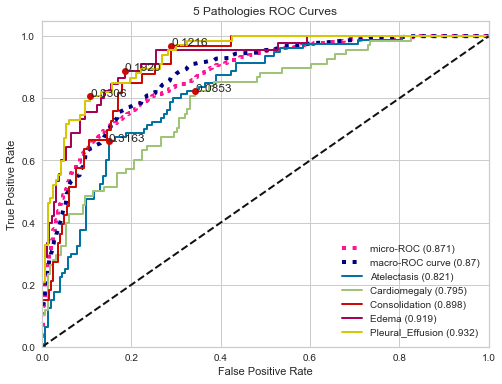

In [173]:
plot_roc(y_true, y_pred, TARGET5_IDX)

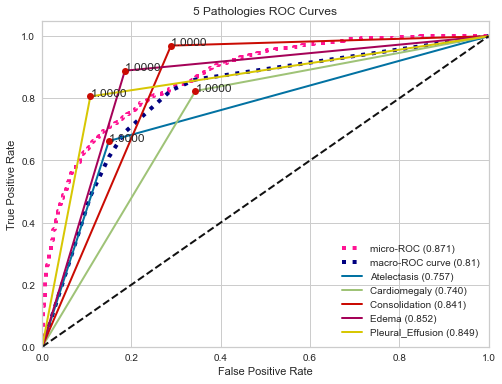

In [174]:
plot_roc(y_true, y_pred, TARGET5_IDX, bthresh)

In [21]:
roc_auc_score(y_true,y_pred, average='micro')

0.8708025539752609

In [319]:
from sklearn import metrics

In [359]:
metrics.f1_score(y_true[:,TARGET5_IDX],y_pred[:,TARGET5_IDX]>bthresh[TARGET5_IDX],average='macro')

0.642770740252201

In [358]:
metrics.f1_score(y_true[:,TARGET13_IDX],y_pred[:,TARGET13_IDX]>bthresh[TARGET13_IDX],average='macro')

0.4737706182733594

In [341]:
t_th = np.clip(bthresh5+np.random.uniform(-0.15,0.15,5),0,1)
roc_auc_score(y_true[:,TARGET5_IDX],y_pred[:,TARGET5_IDX] >= t_th)

0.7363969455690802

In [297]:
t_th2 = bthresh5+np.random.uniform(-0.10,-0.15,5)
roc_auc_score(y_true[:,TARGET5_IDX],y_pred[:,TARGET5_IDX] >= t_th2)

0.6636802202168857

In [258]:
t_th = bthresh5+bthresh5*np.random.uniform(-0.10,-0.15,5)
roc_auc_score(y_true[:,TARGET5_IDX],y_pred[:,TARGET5_IDX] >= t_th)

0.7902258985144253

In [205]:
np.mean([roc_auc_score(y_true[:,TARGET5_IDX],y_pred[:,TARGET5_IDX] >= bthresh5+bthresh5*np.random.uniform(-0.15,0.15,5)) for _ in range(1000)])

0.7896987916506969

In [318]:
np.mean([roc_auc_score(y_true[:,TARGET5_IDX],y_pred[:,TARGET5_IDX] >= bthresh5+np.random.uniform(-0.10,0.10,5)) for _ in range(1000)])

0.7547812347922361